In [1]:
import pathlib as pl
import torch
from torch import nn
from torchvision import io
from torchvision import transforms
import json

data_source_name = "NeRF_Data"
dataset_name = "nerf_synthetic"
scene_name = "lego"

root_data_dir = pl.Path('./data/')
data_path = root_data_dir / data_source_name / dataset_name / scene_name

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.Size([4, 800, 800])
tensor(255, dtype=torch.uint8) tensor(255, dtype=torch.uint8)


C:\Users\gaspa\AppData\Local\Temp\ipykernel_26984\2679499567.py:15: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3618.)
  plt.imshow(train_dataset.ex_img.T.swapaxes(0, 1))


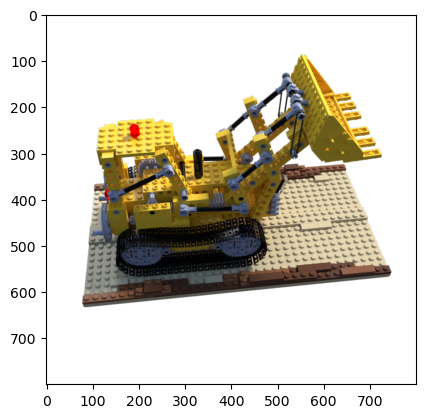

In [2]:
import re
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from src.data import FrameDataset

digit_pattern = re.compile(r"\d+")

   
train_dataset = FrameDataset(data_path, "train")

print(train_dataset.ex_img.shape)
print(train_dataset.ex_img[0].max(), train_dataset.ex_img[3].max())
plt.imshow(train_dataset.ex_img.T.swapaxes(0, 1))

In [3]:
len(train_dataset.img_paths)

100

In [4]:
from src.data import get_rays

H, W = train_dataset.shape
focal = train_dataset.focal
c2w = train_dataset.transform_matrixes[5]

rays_d, rays_o = get_rays(H, W, focal, c2w)
rays_d.shape, rays_o.shape

(torch.Size([800, 800, 3]), torch.Size([800, 800, 3]))

In [5]:
#H, W = 8, 8
L1 = 10
L2 = 4
D = 3

batch_size = 1
n_bins = 100
n_rays = H * W
n_samples = n_bins * n_rays
n_chunks = 400

t_near = 0.1
t_far = 5.0

In [6]:
from src.training import positional_encoding

#tmp_o = torch.randn(batch_size * n_samples * D,device=DEVICE).reshape(batch_size, n_rays, n_bins, D)
#tmp_d = torch.randn(batch_size * n_samples * D,device=DEVICE).reshape(batch_size, n_rays, n_bins, D)
#tex = positional_encoding(tmp_o, L1)
#ted = positional_encoding(tmp_d, L2)


#print("shape:",tex.shape,"memory:",(tex.element_size() * tex.nelement())/1e9,"GB / 5.0 GB")


In [7]:
from src.model import TestNet, MediumNet

mn = MediumNet(L1, L2, 3, 128)
mn = torch.jit.script(mn)
#tn = TestNet(L1, L2, 3, 128)
#tmp_c, tmp_sigma = tn(tex, ted)
#tmp_c.shape, tmp_sigma.shape

In [8]:
from src.training import get_t

tmp_t, tmp_dt = get_t(batch_size, n_rays, n_bins, t_near, t_far)
tmp_t.shape, tmp_dt.shape

(torch.Size([1, 640000, 100]), torch.Size([1, 640000, 99]))

In [9]:
from src.training import expected_color

#tmp_c_hat = expected_color(tmp_c, tmp_sigma, tmp_dt).shape

In [10]:
from src.data import RayDataset

train_render_dataset = RayDataset(train_dataset)
train_render_loader = DataLoader(train_render_dataset, batch_size=batch_size, shuffle=False, num_workers=1, persistent_workers=True, pin_memory=False)

In [11]:
'''
r_o, r_d, C_r = next(iter(train_render_dataset))
r_o = r_o[None, ...].to(DEVICE)
r_d = r_d[None, ...].to(DEVICE)
C_r = C_r[None, ...].to(DEVICE)

B = r_o.size(0)
t, dt = get_t(B, n_rays, n_bins, t_near, t_far)

r_d = nn.functional.normalize(r_d, dim=-1)

r_o = r_o.reshape(B, -1, 1, 3)
r_d = r_d.reshape(B, -1, 1, 3)
t = t[..., None]


pts = r_o + t * r_d
pts, r_d
print(pts.shape, r_d.shape)

ex = positional_encoding(pts, L1)
ed = positional_encoding(r_d, L2)

print(ex.shape, ed.shape)'''

'\nr_o, r_d, C_r = next(iter(train_render_dataset))\nr_o = r_o[None, ...].to(DEVICE)\nr_d = r_d[None, ...].to(DEVICE)\nC_r = C_r[None, ...].to(DEVICE)\n\nB = r_o.size(0)\nt, dt = get_t(B, n_rays, n_bins, t_near, t_far)\n\nr_d = nn.functional.normalize(r_d, dim=-1)\n\nr_o = r_o.reshape(B, -1, 1, 3)\nr_d = r_d.reshape(B, -1, 1, 3)\nt = t[..., None]\n\n\npts = r_o + t * r_d\npts, r_d\nprint(pts.shape, r_d.shape)\n\nex = positional_encoding(pts, L1)\ned = positional_encoding(r_d, L2)\n\nprint(ex.shape, ed.shape)'

In [12]:
from src.training import LitNerf

nerf = LitNerf(mn, n_chunks, n_rays, n_bins, t_near, t_far, L1, L2, learning_rate=3e-4).to(DEVICE)
#nerf.training_step(next(iter(train_render_loader)), 0)

In [13]:
import pytorch_lightning as ptl
#6 bins, 5 128 layers max VRAM
# split img in 196/6 
trainer = ptl.Trainer(max_epochs=10)
trainer.fit(nerf, train_dataloaders=train_render_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\gaspa\miniconda3\envs\env-nerf\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                  | Params
------------------------------------------------------
0 | scene_model | RecursiveScriptModule | 67.5 K
1 | criterion   | MSELoss               | 0     
------------------------------------------------------
67.5 K

Epoch 0:   0%|          | 0/100 [00:00<?, ?it/s] [1, 400, 60] [1, 400, 24]
[1, 400, 60] [1, 400, 24]
[1, 400, 60] [1, 400, 24]
[1, 400, 60] [1, 400, 24]
[1, 400, 60] [1, 400, 24]
[1, 400, 60] [1, 400, 24]
[1, 400, 60] [1, 400, 24]
[1, 400, 60] [1, 400, 24]
[1, 400, 60] [1, 400, 24]
[1, 400, 60] [1, 400, 24]
[1, 400, 60] [1, 400, 24]
[1, 400, 60] [1, 400, 24]
[1, 400, 60] [1, 400, 24]
[1, 400, 60] [1, 400, 24]
[1, 400, 60] [1, 400, 24]
[1, 400, 60] [1, 400, 24]
[1, 400, 60] [1, 400, 24]
[1, 400, 60] [1, 400, 24]
[1, 400, 60] [1, 400, 24]
[1, 400, 60] [1, 400, 24]
[1, 400, 60] [1, 400, 24]
[1, 400, 60] [1, 400, 24]
[1, 400, 60] [1, 400, 24]
[1, 400, 60] [1, 400, 24]
[1, 400, 60] [1, 400, 24]
[1, 400, 60] [1, 400, 24]
[1, 400, 60] [1, 400, 24]
[1, 400, 60] [1, 400, 24]
[1, 400, 60] [1, 400, 24]
[1, 400, 60] [1, 400, 24]
[1, 400, 60] [1, 400, 24]
[1, 400, 60] [1, 400, 24]
[1, 400, 60] [1, 400, 24]
[1, 400, 60] [1, 400, 24]
[1, 400, 60] [1, 400, 24]
[1, 400, 60] [1, 400, 24]
[1, 400, 60] [1

RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
  File "c:\Users\gaspa\dev\projects\torch-nerf\src\model.py", line 64, in <forward op>
    
        x = self.lin1(o)
        x = nn.functional.relu(x)
            ~~~~~~~~~~~~~~~~~~ <--- HERE
        x = self.lin2(x)
        x = nn.functional.relu(x)
  File "c:\Users\gaspa\miniconda3\envs\env-nerf\Lib\site-packages\torch\nn\functional.py", line 1471, in relu
        result = torch.relu_(input)
    else:
        result = torch.relu(input)
                 ~~~~~~~~~~ <--- HERE
    return result
RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacty of 8.00 GiB of which 0 bytes is free. Of the allocated memory 7.34 GiB is allocated by PyTorch, and 14.37 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF



In [ ]:
print("done")